In [1]:
#facial landmark detection; libraries, function, model
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import sys

def imshow(title="image", img=None, size=10):
    w, h = img.shape[0], img.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

!gdown --id 1Fi5nTkCUFLAhs8d9Yg9zA7fxcTnwsL8r
!unzip --qq /content/shape_predictor_68_face_landmarks.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Fi5nTkCUFLAhs8d9Yg9zA7fxcTnwsL8r
From (redirected): https://drive.google.com/uc?id=1Fi5nTkCUFLAhs8d9Yg9zA7fxcTnwsL8r&confirm=t&uuid=480e1211-046c-4c7b-94ba-817c656f7cac
To: /content/shape_predictor_68_face_landmarks.zip
100% 72.3M/72.3M [00:00<00:00, 228MB/s]
replace __MACOSX/._shape_predictor_68_face_landmarks.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


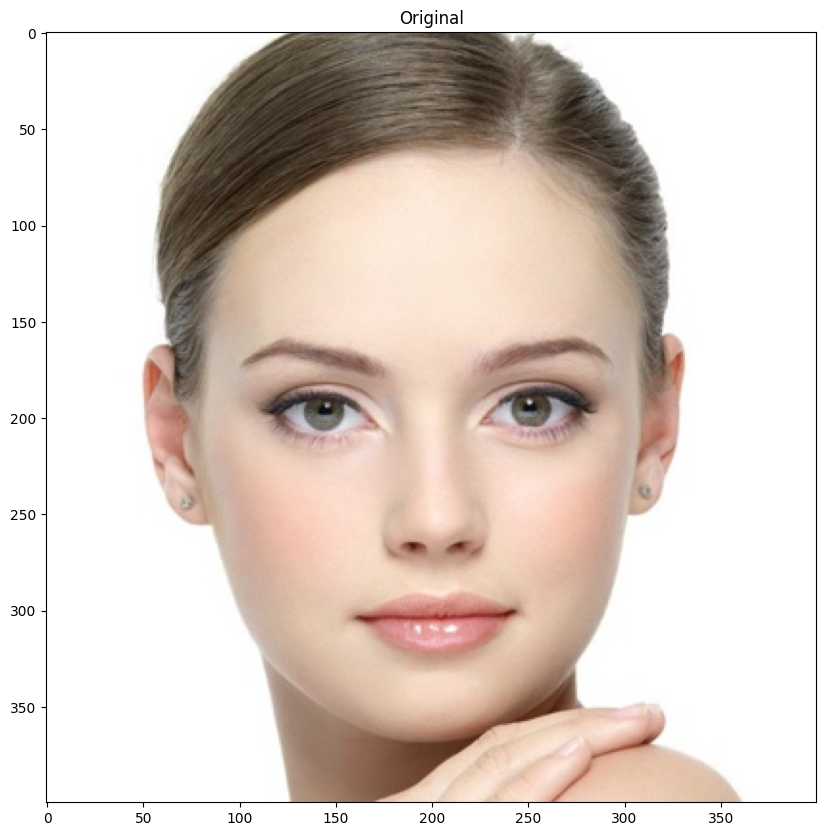

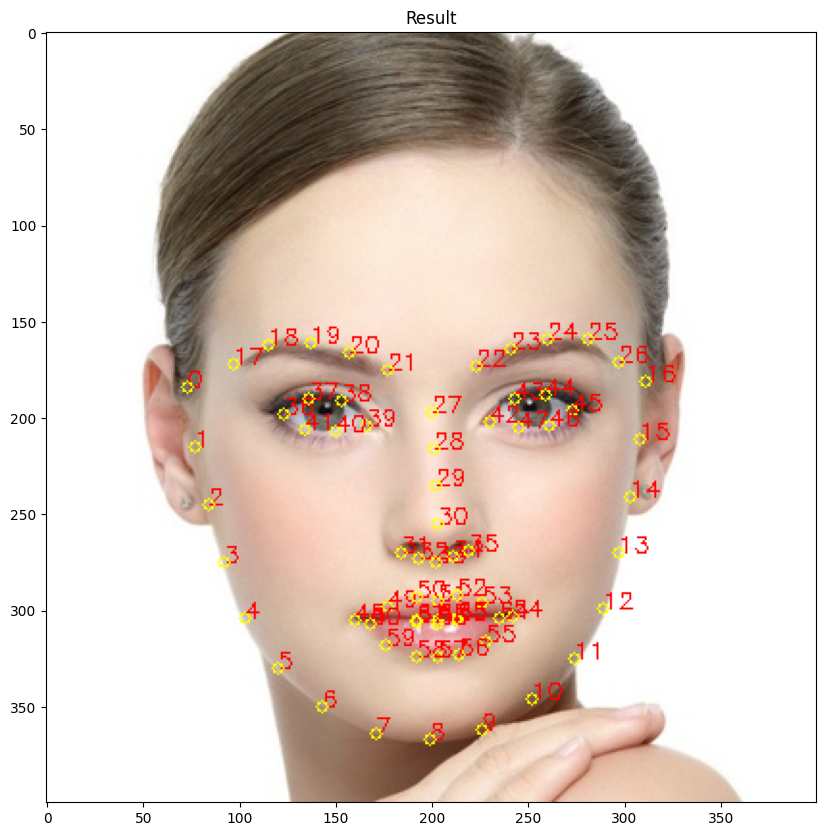

In [2]:
PREDICTOR_PATH = "/content/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    if len(rects) > 1:
        raise TooManyFaces("Multiple faces detected")
    if len(rects) == 0:
        raise NoFaces("No faces detected")
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

image = cv2.imread('/content/image_1.jpg')
imshow('Original', image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
imshow('Result', image_with_landmarks)

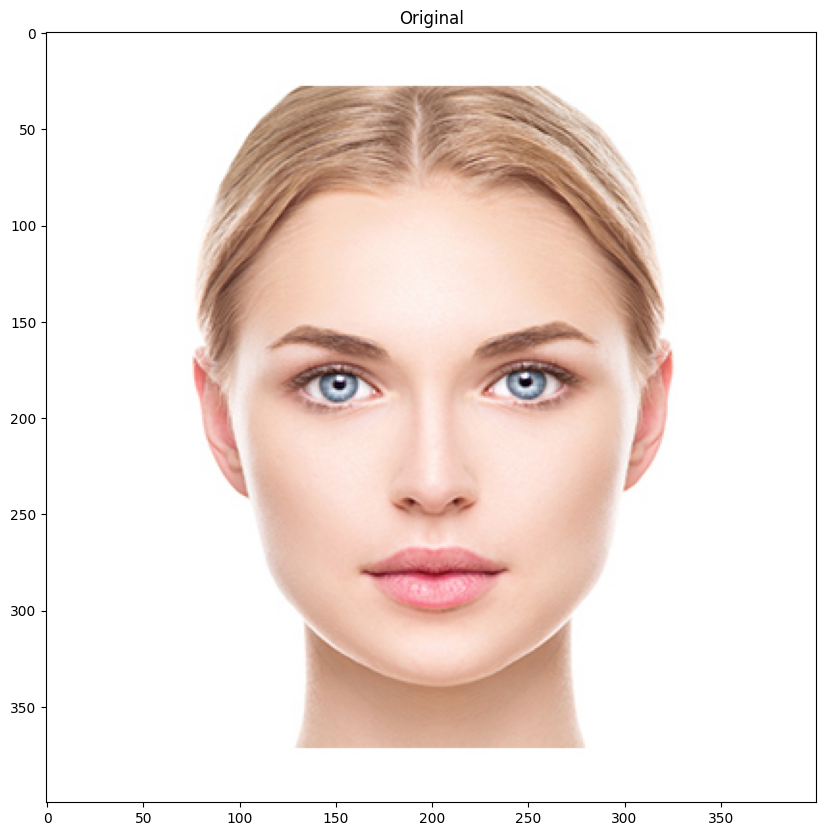

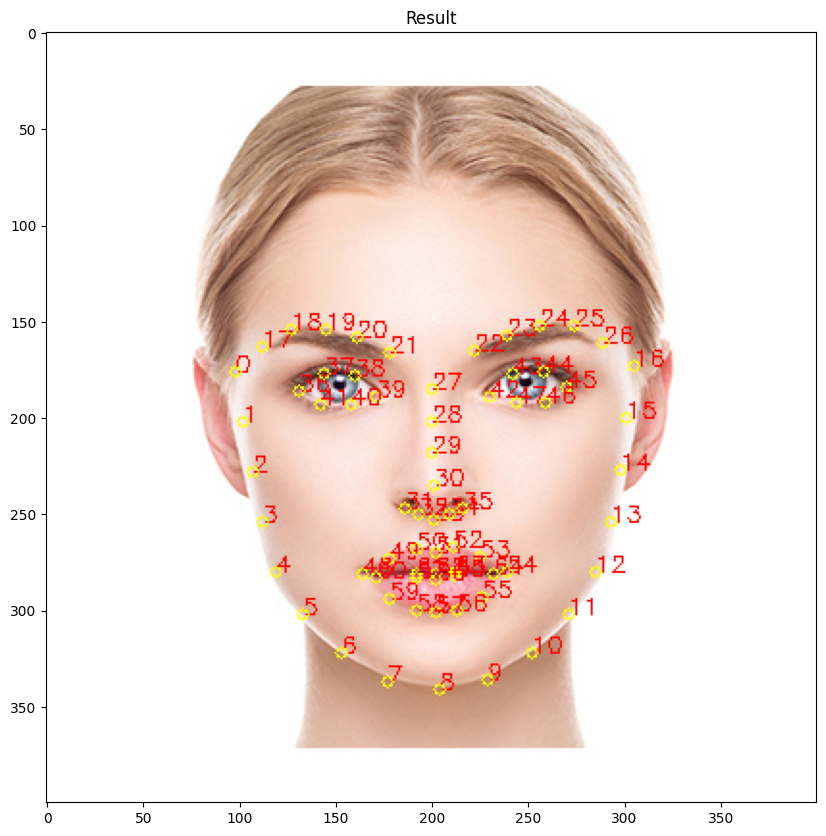

In [3]:
image = cv2.imread('/content/image_2.jpg')
imshow('Original', image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
imshow('Result', image_with_landmarks)

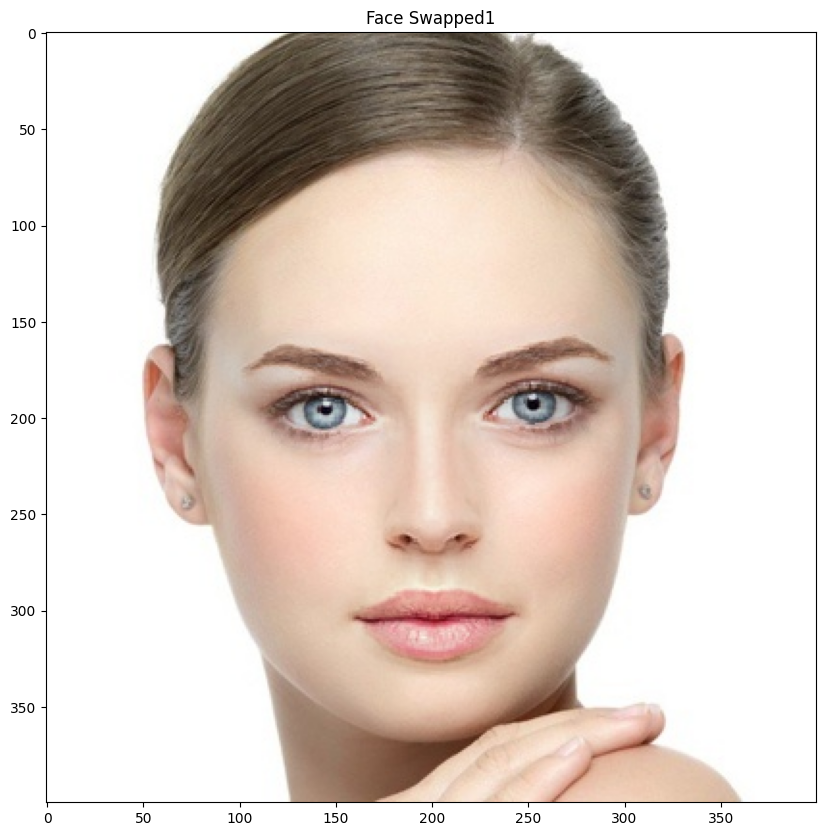

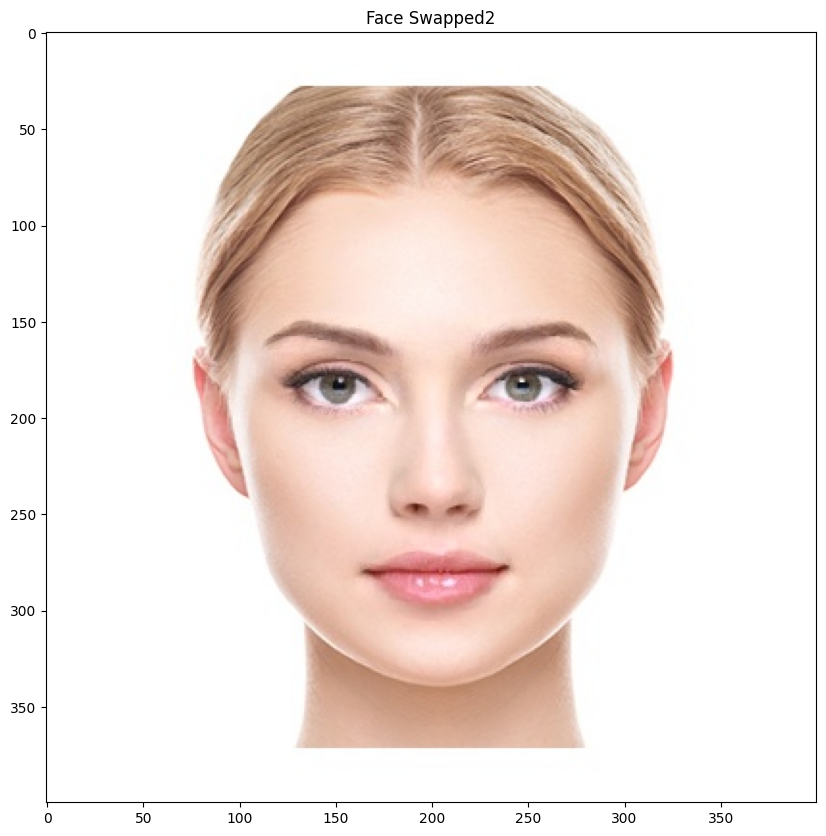

In [4]:
SCALE_FACTOR=1
FEATHER_AMOUNT=11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)
    im=np.array([im,im,im]).transpose((1,2,0))
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)
    return im

def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def read_im_and_landmarks(image):
    im = image
    im = cv2.resize(im, None, fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                        im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)
    return im, s

def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)
    return (im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64))


#swappy function
def swappy(image1,image2):
    im1, landmarks1 = read_im_and_landmarks(image1)
    im2, landmarks2 = read_im_and_landmarks(image2)
    M = transformation_from_points(landmarks1[ALIGN_POINTS], landmarks2[ALIGN_POINTS])
    mask = get_face_mask(im2, landmarks2)
    warped_mask = warp_im(mask, M, im1.shape)
    combined_mask = np.max([get_face_mask(im1, landmarks1), warped_mask], axis=0)

    warped_im2 = warp_im(im2, M, im1.shape)
    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
    cv2.imwrite('output.jpg',output_im)
    img=cv2.imread('output.jpg')
    return img

#paths for photos
image1=cv2.imread('/content/image_1.jpg')
image2=cv2.imread('/content/image_2.jpg')

#call swappy function
swpd=swappy(image1,image2)
imshow('Face Swapped1', swpd)

swpd2=swappy(image2,image1)
imshow('Face Swapped2', swpd2)

